In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

Customer = spark.read.csv("MsCustomer.csv", header=True, inferSchema=True)
Driver = spark.read.csv("MsDriver.csv", header=True, inferSchema=True)
Food = spark.read.csv("MsFood.csv", header=True, inferSchema=True)
Restaurant = spark.read.csv("MsRestaurant.csv", header=True, inferSchema=True)
TransactionHeader = spark.read.csv("TransactionHeader.csv", header=True, inferSchema=True)
TransactionDetail = spark.read.csv("TransactionDetail.csv", header=True, inferSchema=True)

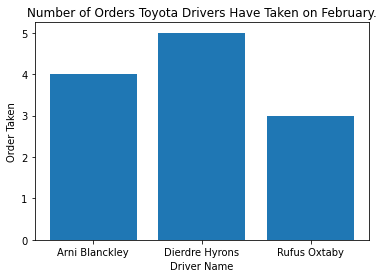

In [ ]:
import matplotlib.pyplot as plot

# a.	Show how many orders JrebFood drivers who drived using Toyota have taken in February using barplot.
# driverToyota = spark.sql("""
#   SELECT d.DriverName AS Name, COUNT(th.TransactionId) AS Count
#   FROM Driver d
#   JOIN TransactionHeader th on th.DriverId = d.DriverId
#   WHERE d.DriverVehicle = 'Toyota' AND MONTH(th.TransactionDate) = 2
#   GROUP BY Name
# """).show()

driverToyota = spark.sql("""
  SELECT d.DriverName AS Name, COUNT(th.TransactionId) AS Count
  FROM Driver d
  JOIN TransactionHeader th on th.DriverId = d.DriverId
  WHERE d.DriverVehicle = 'Toyota' AND MONTH(th.TransactionDate) = 2
  GROUP BY Name
""").toPandas()

plot.bar(driverToyota["Name"], driverToyota["Count"])
plot.title("Number of Orders Toyota Drivers Have Taken on February.")
plot.xlabel("Driver Name")
plot.ylabel("Order Taken")
plot.show()

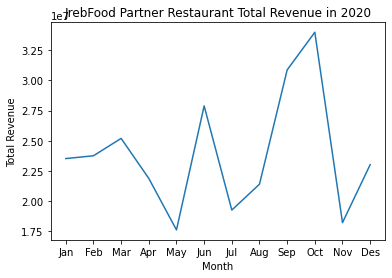

In [ ]:
# b.	Show JrebFood partner restaurant revenue for every month in 2020 using line plot.
# restaurantRevenue = spark.sql("""
#   SELECT SUM(f.FoodPrice * td.Quantity) AS Revenue
#   FROM Restaurant r
#   JOIN TransactionHeader th on th.RestaurantId = r.RestaurantId
#   JOIN TransactionDetail td on td.TransactionId = th.TransactionId
#   JOIN Food f on f.FoodId = td.FoodId
#   WHERE r.IsPartner = 'true'
#   GROUP BY MONTH(th.TransactionDate)
# """).show()

restaurantRevenue = spark.sql("""
  SELECT SUM(f.FoodPrice * td.Quantity) AS Revenue, MONTH(th.TransactionDate) AS Month,
  CASE
    WHEN MONTH(th.TransactionDate) = 1 THEN 'Jan'
    WHEN MONTH(th.TransactionDate) = 2 THEN 'Feb'
    WHEN MONTH(th.TransactionDate) = 3 THEN 'Mar'
    WHEN MONTH(th.TransactionDate) = 4 THEN 'Apr'
    WHEN MONTH(th.TransactionDate) = 5 THEN 'May'
    WHEN MONTH(th.TransactionDate) = 6 THEN 'Jun'
    WHEN MONTH(th.TransactionDate) = 7 THEN 'Jul'
    WHEN MONTH(th.TransactionDate) = 8 THEN 'Aug'
    WHEN MONTH(th.TransactionDate) = 9 THEN 'Sep'
    WHEN MONTH(th.TransactionDate) = 10 THEN 'Oct'
    WHEN MONTH(th.TransactionDate) = 11 THEN 'Nov'
    WHEN MONTH(th.TransactionDate) = 12 THEN 'Des'
  END AS MonthFormat
  FROM Restaurant r
  JOIN TransactionHeader th on th.RestaurantId = r.RestaurantId
  JOIN TransactionDetail td on td.TransactionId = th.TransactionId
  JOIN Food f on f.FoodId = td.FoodId
  WHERE r.IsPartner = 'true'
  GROUP BY MONTH(th.TransactionDate)
  ORDER BY Month
""").toPandas()

plot.plot(restaurantRevenue["MonthFormat"], restaurantRevenue["Revenue"])
plot.title("JrebFood Partner Restaurant Total Revenue in 2020")
plot.ylabel("Total Revenue")
plot.xlabel("Month")
plot.show()

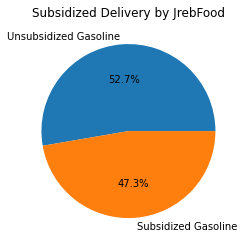

In [ ]:
# c.	Show the percentage of deliveries that JrebFood subsidize using pie plot.
# The delivery will be subsidized based on the distance of the delivery as follows:

# percentageSubsidize = spark.sql("""
#   SELECT COUNT(th.Distance)
#   FROM TransactionHeader th, (
#     SELECT th.Distance AS Distance,
#     CASE
#       WHEN th.Distance > AverageDistance THEN 'Subsidized Gasoline'
#       WHEN th.Distance <= AverageDistance THEN 'Unsubsidized Gasoline'
#     END AS Subsidize
#     FROM TransactionHeader th, (
#       SELECT AVG(th.Distance) AS AverageDistance
#       FROM TransactionHeader th
#       WHERE MONTH(th.TransactionDate) = 1
#     )
#   )
#   GROUP BY Subsidize
# """).show()

percentageSubsidize = spark.sql("""
  SELECT COUNT(th.Distance) AS Count, Subsidize
  FROM TransactionHeader th, (
    SELECT th.Distance,
    CASE
      WHEN th.Distance > AverageDistance THEN 'Subsidized Gasoline'
      WHEN th.Distance <= AverageDistance THEN 'Unsubsidized Gasoline'
    END AS Subsidize
    FROM TransactionHeader th, (
      SELECT AVG(th.Distance) AS AverageDistance
      FROM TransactionHeader th
      WHERE MONTH(th.TransactionDate) = 1
    )
  )
  GROUP BY Subsidize
""").toPandas()

plot.pie(percentageSubsidize["Count"], labels=percentageSubsidize["Subsidize"], autopct="%.1f%%")
plot.title("Subsidized Delivery by JrebFood")
plot.show()

In [ ]:
# a. Load Data
storm_train = spark.read.csv("Storm_Training.csv", header=True, inferSchema=True)
storm_testing = spark.read.csv("Storm_Testing.csv", header=True, inferSchema=True)

storm_train.show(5)
storm_testing.show(5)

+--------------------+-------------+--------------+----------+---------+----------------+-----------+---------------+------------+
|atmospheric_pressure|visible_cloud|wind_direction|wind_speed|sky_color|ocean_wave_speed|temperature|animal_activity|storm_coming|
+--------------------+-------------+--------------+----------+---------+----------------+-----------+---------------+------------+
|              1006.5|       Cirrus|          East|      78.8|    Green|            High|     Stable|           High|          No|
|              1013.5| Cumulonimbus|         South|      51.6|   Orange|          Medium|    Decline|         Medium|         Yes|
|              1013.2|       Cirrus|         South|      69.7|   Orange|            High|     Stable|           High|         Yes|
|              1011.3| Cumulonimbus|          null|      59.3|   Orange|             Low|     Stable|            Low|         Yes|
|              1013.0| Cumulonimbus|          West|      66.7|   Orange|           

In [ ]:
# b. Select Features
storm_train = storm_train.select("wind_speed", "temperature", "sky_color", "storm_coming")
storm_testing = storm_testing.select("wind_speed", "temperature", "sky_color", "storm_coming")

In [ ]:
# c. Data Processing
storm_train = storm_train.na.drop()
storm_testing = storm_testing.na.drop()

In [ ]:
from pyspark.sql.functions import when

# d. Transform Data
storm_train = storm_train.withColumn("temperature", when(storm_train["temperature"] == "Decline", 0).when(storm_train["temperature"] == "Stable", 1).otherwise(2))
storm_train = storm_train.withColumn("sky_color", when(storm_train["sky_color"] == "Green", 0).when(storm_train["sky_color"] == "Orange", 1).otherwise(2))

storm_testing = storm_testing.withColumn("temperature", when(storm_testing["temperature"] == "Stable", 0).when(storm_testing["temperature"] == "Stable", 1).otherwise(2))
storm_testing = storm_testing.withColumn("sky_color", when(storm_testing["sky_color"] == "Green", 0).when(storm_testing["sky_color"] == "Orange", 1).otherwise(2))


In [ ]:
from pyspark.ml.feature import StandardScaler, VectorAssembler

# e. Normalization
storm_train = VectorAssembler(inputCols=["wind_speed", "temperature", "sky_color"], outputCol="FeaturesTrain").transform(storm_train)
storm_train = StandardScaler(inputCol="FeaturesTrain", outputCol="FeaturesTrainNormed").fit(storm_train).transform(storm_train)

storm_testing = VectorAssembler(inputCols=["wind_speed", "temperature", "sky_color"], outputCol="FeaturesTest").transform(storm_testing)
storm_testing = StandardScaler(inputCol="FeaturesTest", outputCol="FeaturesTestNormed").fit(storm_testing).transform(storm_testing)

In [ ]:
from pyspark.ml.classification import LogisticRegression

